In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
import sklearn


In [2]:
# Reading the input 
train_data =pd.read_csv("content_time/train.csv")
test_data =pd.read_csv("content_time/test.csv")
oil_data = pd.read_csv("content_time/oil.csv")
stores_data = pd.read_csv("content_time/stores.csv")
holidays_data = pd.read_csv("content_time/holidays_events.csv")

## Exploration of the dataset

In [3]:
print( train_data.shape )
train_data.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_data["date"]= pd.to_datetime( train_data["date"] )

In [5]:
print( train_data["family"].unique() )
train_data["family"].unique().shape

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


(33,)

In [6]:
print(train_data["store_nbr"].unique())
train_data["store_nbr"].unique().shape

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


(54,)

In [7]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Text(0.5, 1.0, 'Total Sales per Year')

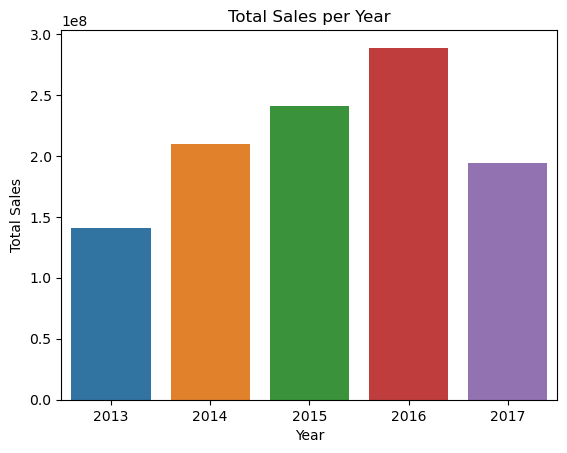

In [8]:
yearly_sales = train_data.groupby(train_data["date"].dt.year)["sales"].sum().reset_index()
fig = sns.barplot(x=yearly_sales["date"], y=yearly_sales["sales"])
fig.set(xlabel="Year", ylabel="Total Sales")
fig.set_title("Total Sales per Year")


Text(0.5, 1.0, 'Average Sales per Day of the Month')

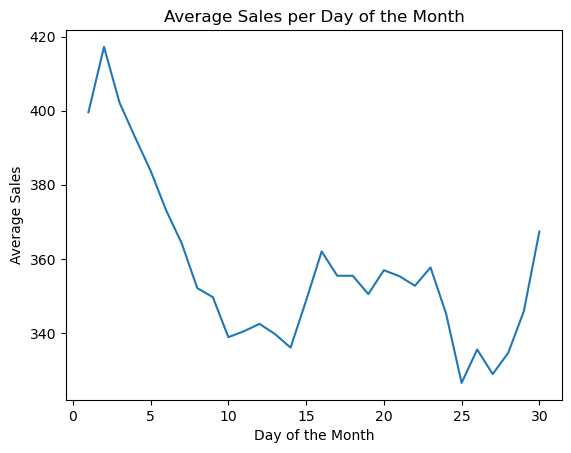

In [9]:

daily_sales_per_month = train_data.groupby(train_data["date"].dt.day)["sales" ].mean().reset_index()
daily_sales_per_month.drop(index = 30, axis=0, inplace = True)

fig = sns.lineplot(x=daily_sales_per_month["date"], y=daily_sales_per_month["sales"])
fig.set(xlabel="Day of the Month", ylabel="Average Sales")
fig.set_title("Average Sales per Day of the Month")

Text(0.5, 1.0, 'Total Sales per Day')

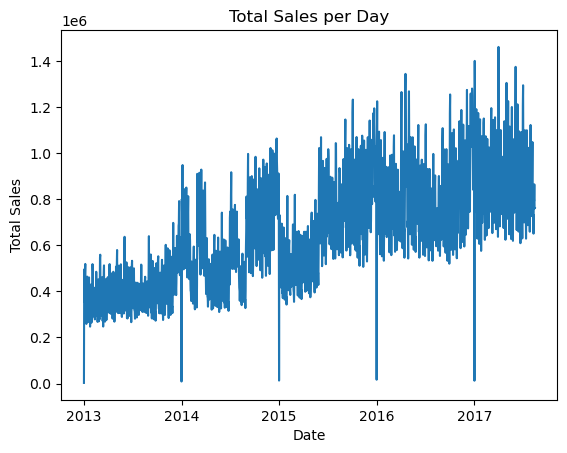

In [10]:
# Group data by date and calculate the total sales for each day
total_sales=train_data[["sales" , "date"]].groupby("date").sum().reset_index()

fig = sns.lineplot(x=total_sales["date"], y=total_sales["sales"])
fig.set(xlabel="Date", ylabel="Total Sales")
fig.set_title("Total Sales per Day")


<p style = "color: lightblue">Il y a toujours un drop de vente au premier janvier</p>

In [11]:
print(oil_data.shape)
oil_data.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [12]:
oil_data["date"]=pd.to_datetime(oil_data["date"])

In [13]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

Text(0.5, 1.0, 'Daily Oil Price')

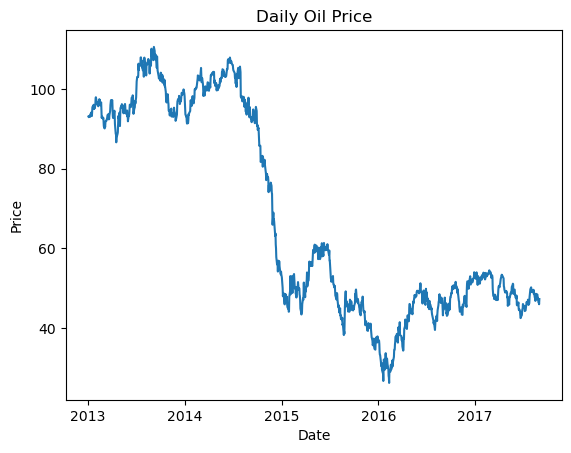

In [14]:
fig = sns.lineplot(x=oil_data["date"], y=oil_data["dcoilwtico"])
fig.set(xlabel="Date", ylabel="Price")
fig.set_title("Daily Oil Price")

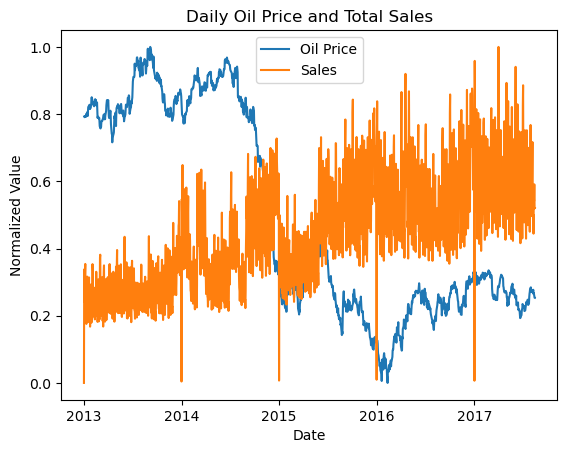

In [15]:
from sklearn.preprocessing import MinMaxScaler

#Plotting the total sales and oil prices on the same plot 
total_sales = total_sales.merge(oil_data, on="date", how="left", suffixes=('', '_oil'))


scaler = MinMaxScaler()
total_sales["dcoilwtico"] = scaler.fit_transform(total_sales[["dcoilwtico"]])  
total_sales["sales"] = scaler.fit_transform(total_sales[["sales"]])  

fig = sns.lineplot(x=total_sales["date"], y=total_sales["dcoilwtico"], label="Oil Price")
fig = sns.lineplot(x=total_sales["date"], y=total_sales["sales"], label="Sales")
fig.set(xlabel="Date", ylabel="Normalized Value")
fig.set_title("Daily Oil Price and Total Sales")

total_sales["sales"] = scaler.inverse_transform(total_sales[["sales"]])


In [16]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [18]:
print(stores_data["type"].unique())
print(stores_data["type"].unique().shape)


['D' 'B' 'C' 'E' 'A']
(5,)


In [19]:
print(stores_data["cluster"].unique())
print(stores_data["cluster"].unique().shape)

[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]
(17,)


In [20]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [21]:
# Convert the date column to a datetime type
holidays_data["date"] = pd.to_datetime( holidays_data["date"] )

In [22]:
holidays_data["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [23]:
holidays_data["date"].duplicated().any()

True

<p style="color:lightblue">Plusieurs valeurs dupliquées, plusieurs vacances peuvent se chevaucher</p>

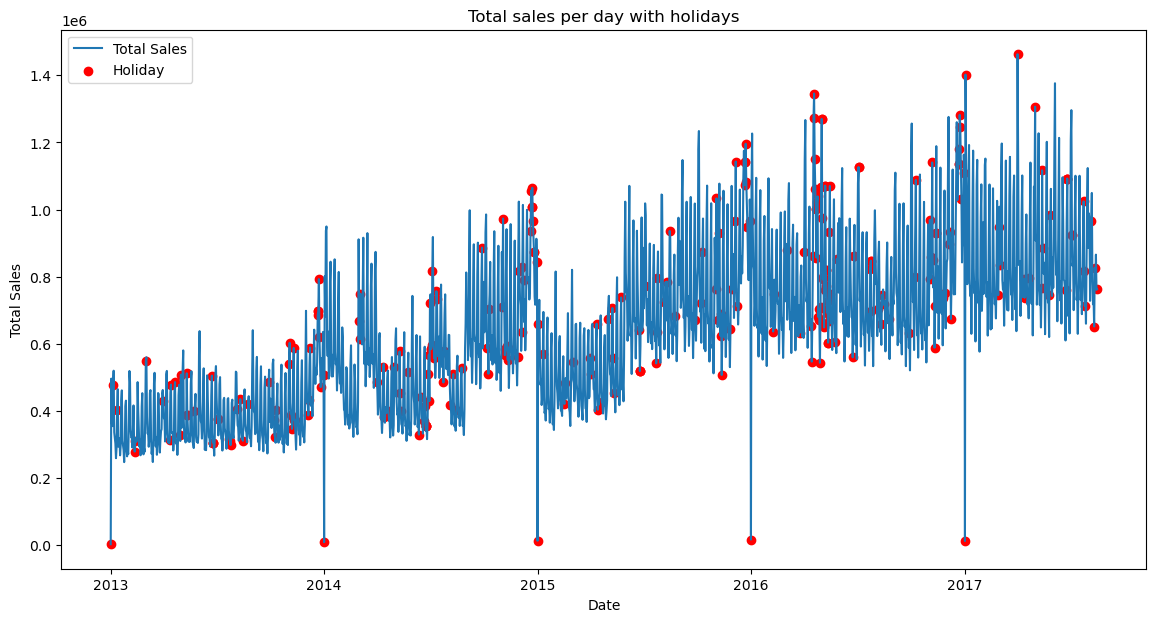

In [24]:
import matplotlib.pyplot as plt
holidays = holidays_data.merge(total_sales, on="date", how="left")


plt.figure(figsize=(14, 7))
sns.lineplot(data=total_sales, x="date", y="sales", label="Total Sales")

plt.scatter(holidays["date"], holidays["sales"], color='red', label="Holiday", marker='o')


plt.title("Total sales per day with holidays")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()


## **Lag Analysis**

In [25]:
train_data['log_sales'] = np.log1p(train_data['sales'])
log_target_column = 'log_sales'

In [27]:
lag_values = range(1, 366)
correlations = {}

# Calculer les corrélations pour chaque valeur de lag
for lag_value in lag_values:
    lag_column = f'{log_target_column}_lag_{lag_value}'
    if lag_column not in train_data.columns:
        train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
    correlation = train_data[[log_target_column, lag_column]].corr().loc[log_target_column, lag_column]
    correlations[lag_value] = correlation

# Convertir le dictionnaire en DataFrame pour faciliter le tri
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Lag', 'Correlation'])

# Trier les corrélations par ordre décroissant
sorted_correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Afficher les lags les plus corrélés
top_n = 10  # Nombre de lags les plus corrélés à afficher
print(f'Top {top_n} lags les plus corrélés:')
sorted_correlation_df.head(top_n)

/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_7968/3719122353.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_7968/3719122353.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_7968/3719122353.py:8: PerformanceWarning: DataFrame is highly f

Top 10 lags les plus corrélés:


,Lag,Correlation
32,33,0.824213
362,363,0.810805
65,66,0.793658
263,264,0.788757
230,231,0.779355
98,99,0.770194
296,297,0.766928
329,330,0.765155
131,132,0.762072
164,165,0.757744


<p style="color:lightblue">Calcul du lag pour voir quels sont les jours qui ont le plus d'influence sur le présent</p>

# Preprocessing

In [26]:
#Creating a function to prepare the data merging the dataframes and adding features (lag, trend, seasonality)
def prepare_data(df):
    
    X = df.copy()
    
    X = X.merge(stores_data, on = "store_nbr", how = "left")
    
    # Join the daily oil prices with the training data
    X = X.merge( oil_data, on = "date", how = "left")
    
    # Add a feature for the day of the month
    X["day"] = X["date"].dt.day
    
    # Add a feature for the name of the day  (e.g., 'Monday', 'Tuesday')
    X["day_name"] = X["date"].dt.day_name()
    
    # Add a boolean feature to know if it's the end of the month
    X["is_month_end"] = X["date"].dt.is_month_end
    
    # Add a boolean feature to know if it's the middle of the month
    X["is_month_middle"] = X["date"].dt.day == 15

    

    # Add trend features ( Order 2 )
    date = X["date"].unique()
    trend = np.arange(date.shape[0])
    trend_features = pd.DataFrame({
        "date" : date,
        "trend" : trend,
        "trend_squared":np.square(trend)
        }    
    )
    trend_features["date"] = pd.to_datetime(trend_features["date"])
    X = X.merge( trend_features ,on="date",how="left")


    # Add yearly seasonality  ( Order 1 )
    X["sin_day_of_year"] = np.sin(2 * np.pi * X["date"].dt.dayofyear / 365)
    X["cos_day_of_year"] = np.cos(2 * np.pi * X["date"].dt.dayofyear / 365)
    
    # Add monthly seasonality ( Order 1 )
    X["sin_month"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["cos_month"] = np.cos(2 * np.pi * X["date"].dt.month / 12)

    # Add lag features
    X["sales_lag_33"] = X.groupby(["family","store_nbr" ])["sales"].shift(33)
    X["sales_lag_363"] = X.groupby(["family","store_nbr" ])["sales"].shift(363)


    X=X.drop ( ["date" , "id"] ,axis=1)

    return X 


In [27]:
# We wont't be using all the data for training 
# We will just use the data starting form 2015-7-1 because the trend repeat itself before that date

# Training set indicies
training_start = train_data[train_data["date"] == pd.to_datetime("2015-7-1")].index[0]
training_end = train_data[train_data["date"] == pd.to_datetime("2017-8-1")].index[0] #The last day of the training and testing set

validation_start = train_data[train_data["date"] == pd.to_datetime("2017-8-2")].index[0] #The first day of the validation

# Printing the results
print("Training Start: ", training_start)
print("Training End: ", training_end)
print("Validation Start: ", validation_start)

Training Start:  1619838
Training End:  2974158
Validation Start:  2975940


In [28]:
X_train = prepare_data(train_data)
X_train.head()

,store_nbr,family,sales,onpromotion,log_sales,city,state,type,cluster,dcoilwtico,...,is_month_end,is_month_middle,trend,trend_squared,sin_day_of_year,cos_day_of_year,sin_month,cos_month,sales_lag_33,sales_lag_363
0,1,AUTOMOTIVE,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,False,0,0,0.017213,0.999852,0.5,0.866025,NaN,NaN
1,1,BABY CARE,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,False,0,0,0.017213,0.999852,0.5,0.866025,NaN,NaN
2,1,BEAUTY,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,False,0,0,0.017213,0.999852,0.5,0.866025,NaN,NaN
3,1,BEVERAGES,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,False,0,0,0.017213,0.999852,0.5,0.866025,NaN,NaN
4,1,BOOKS,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,False,0,0,0.017213,0.999852,0.5,0.866025,NaN,NaN


In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical features that need preprocessing
cat_features=["family","city","state","type","day_name"]
# Continuous features that need preprocessing
cont_features = ["dcoilwtico"] 

# pipeline for continuous features
cont_pipeline=make_pipeline(
    SimpleImputer(strategy = "mean"),
    StandardScaler()
)

# Pipeline for categorical features
cat_pipeline=make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown="ignore",sparse_output=False)
)

# Combine the pipelines using ColumnTransformer
preprocessor=ColumnTransformer(
    transformers=[
        ("cont",cont_pipeline,cont_features),
        ("cat",cat_pipeline,cat_features)
        
    ],
    remainder='passthrough'
)

model=xgb.XGBRegressor( objective = "reg:tweedie", random_state = 0  ) 

# Combine the preprocessor and model into a single pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model',model)
])


In [30]:
# Drop the sales column from the dataframe
y_train = X_train["sales"]
X_train = X_train.drop("sales" , axis = 1 )

X_train = X_train[training_start : training_end :]
y_train = y_train[training_start : training_end :]

X_train.head()

,store_nbr,family,onpromotion,log_sales,city,state,type,cluster,dcoilwtico,day,...,is_month_end,is_month_middle,trend,trend_squared,sin_day_of_year,cos_day_of_year,sin_month,cos_month,sales_lag_33,sales_lag_363
1619838,1,AUTOMOTIVE,0,1.791759,Quito,Pichincha,D,13,56.94,1,...,False,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,2.0,1.0
1619839,1,BABY CARE,0,0.000000,Quito,Pichincha,D,13,56.94,1,...,False,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,0.0,0.0
1619840,1,BEAUTY,1,1.791759,Quito,Pichincha,D,13,56.94,1,...,False,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,0.0,3.0
1619841,1,BEVERAGES,2,7.878155,Quito,Pichincha,D,13,56.94,1,...,False,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,2194.0,2803.0
1619842,1,BOOKS,0,0.000000,Quito,Pichincha,D,13,56.94,1,...,False,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,0.0,0.0


In [31]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
#Fit the pipeline to the training data
final_pipeline.fit(X_train,y_train)
predictions = final_pipeline.predict(X_train)

print("Training Error: ")
print("RMSLE:", np.sqrt(mean_squared_log_error(predictions, y_train)))
print("MAE:",mean_absolute_error(predictions, y_train ))
print("R2:",r2_score(predictions, y_train ))

Training Error: 
RMSLE: 0.01054647373351776
MAE: 9.484322269458643
R2: 0.9966594158443849


# Model training

In [32]:

y_validation = train_data["sales"][validation_start : : ].copy()

train_data["sales"][validation_start : : ] = np.nan


X_validation =prepare_data(train_data)
X_validation = X_validation [validation_start : :]

X_validation = X_validation.drop("sales" ,axis = 1 )

/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_8158/2306730903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["sales"][validation_start : : ] = np.nan


In [33]:
valid_predictions = final_pipeline.predict(X_validation)
print("Validation Error: ")
print("RMSLE:", np.sqrt(mean_squared_log_error( valid_predictions, y_validation ) ))
print("MAE:", mean_absolute_error( valid_predictions, y_validation ) )
print("R2:", r2_score( valid_predictions, y_validation ) )

Validation Error: 
RMSLE: 0.013497908031801948
MAE: 13.151277875434847
R2: 0.9918097208458089


In [37]:
import optuna

def objective(trial):

    params = {
       "model__n_estimators": trial.suggest_int("model__n_estimators", 50, 1000),  
         "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.3, log=True),  
         "model__min_child_weight": trial.suggest_int("model__min_child_weight", 1, 6),  
         "model__max_depth": trial.suggest_int("model__max_depth", 3, 15),  
         "model__subsample": trial.suggest_float("model__subsample", 0.5, 1.0, step=0.1),  
         "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.5, 1.0, step=0.1),  
         "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-3, 10.0, log=True),  
         "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-3, 10.0, log=True)  
         }

    # Create a new pipeline with the parameters
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', xgb.XGBRegressor(objective="reg:tweedie", random_state=0, **params))
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_validation)
    rmsle = np.sqrt(mean_squared_log_error(y_validation, preds))
    return rmsle


study = optuna.create_study( direction="minimize", sampler=optuna.samplers.TPESampler(seed = 0) )
study.optimize(objective, n_trials=100 , n_jobs=2)
best_parameters =  study.best_trial.params
final_pipeline.set_params(**best_parameters)

[I 2024-12-13 09:01:05,914] A new study created in memory with name: no-name-42d8cbba-035e-4f12-bc1c-dd208e0d236a
[09:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

[09:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

[I 2024-12-13 09:02:01,414] Trial 1 finished with value: 0.013497908031801948 and parameters: {'model__n_estimators': 180, 'model__learning_rate': 0.01479569790511928, 'model__min_child_weight': 6, 'model__max_depth': 4, 'model__subsample': 0.5, 'model__colsample_bytree': 0.9, 'model__reg_lambda': 0.035162616

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.01479569790511928, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=6, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=180, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [ ]:
best_parameters = {'model__n_estimators': 180, 'model__learning_rate': 0.01479569790511928, 'model__min_child_weight': 6, 'model__max_depth': 4, 'model__subsample': 0.5, 'model__colsample_bytree': 0.9, 'model__reg_lambda': 0.035162616215552306, 'model__reg_alpha': 0.003642341918466777}
final_pipeline.set_params(**best_parameters)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03974568823588938, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=14,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [39]:
# Retrain the model on both the training and validation sets

# Reread the training data to make sure it was not changed 
train_data =pd.read_csv("content_time/train.csv")
train_data["date"] = pd.to_datetime(train_data["date"])

X_all = prepare_data( train_data  )
X_all = X_all[training_start : :]
y_all = X_all["sales"]
X_all = X_all.drop("sales" , axis = 1)


final_pipeline.fit( X_all , y_all )

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03974568823588938, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=14,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [40]:
valid_predictions = final_pipeline.predict(X_validation)
print("Validation Error: ")
print("RMSLE:",np.sqrt(mean_squared_log_error(valid_predictions, y_validation )))
print("MAE:",mean_absolute_error(valid_predictions, y_validation ))
print("R2:",r2_score(valid_predictions, y_validation ))

Validation Error: 
RMSLE: 0.2553220309206382
MAE: 23.900523508156574
R2: 0.9970699621218574


# Submission

In [41]:
test_size=test_data.shape[0]
# Concatenate the test data with the training data (We need the training data for  lag features)
test_data = pd.concat([train_data , test_data])
# Convert the date column to datetime type
test_data["date"]= pd.to_datetime(test_data["date"])

In [42]:
# Save the IDs column for the test data ( Needed for the submission) 
ids = test_data["id"].tail(test_size)

test_data=prepare_data(test_data)

test_data = test_data.tail(test_size)
test_data.drop(["sales" ] , axis =1 , inplace =True)

In [43]:
test_predictions=final_pipeline.predict(test_data)

# Put the test predictions in a CSV file
test_predictions=test_predictions.reshape(-1)
output = pd.DataFrame({'id': ids, 'sales': test_predictions})
output.to_csv('submission.csv', index=False)

output.head()

,id,sales
0,3000888,4.187808
1,3000889,0.000128
2,3000890,5.244135
3,3000891,2369.854004
4,3000892,0.003958
